In [1]:
# !pip install dgl
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !sudo apt-get install -y fonts-nanum


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='fiona._env')

F0 = '/content/gdrive/My Drive/seoulmovingdata/시도경계/LARD_ADM_SECT_SGG_11.shp'
map0 = gpd.read_file(F0, encoding='cp949')
map0 = map0.sort_values(by='SGG_NM')


# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]

os.environ['SHAPE_ENCODING'] = "UTF-8"
F2 = '/content/gdrive/My Drive/seoulmovingdata/상권지도/TBGIS_TRDAR_RELM.shp'
map2 = gpd.read_file(F2, encoding='UTF-8')

F3 = '/content/gdrive/My Drive/seoulmovingdata/시도경계/LARD_ADM_SECT_SGG_11.shp'
map3 = gpd.read_file(F3, encoding='cp949')
map3 = map3.sort_values(by='SGG_NM')
# map3['SGG_NM'].unique().tolist()
# sorted(map3['SGG_NM'].unique().tolist())

#기타 서울 관련

file_seuol_1 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(자치구별 상권변화지표) (1).csv'
graphic1 = pd.read_csv(file_seuol_1, encoding='cp949', index_col = None)
file_seuol_2 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(행정동별 상권변화지표).csv'
graphic2 = pd.read_csv(file_seuol_2, encoding='cp949', index_col = None)
# file_seuol_3 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(상권배후지-추정매출).csv'
# graphic3 = pd.read_csv(file_seuol_3, encoding='cp949', index_col = None)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  3518 non-null   object  
 1   ADM_CD     3518 non-null   int64   
 2   ADM_NM     3518 non-null   object  
 3   geometry   3518 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 110.1+ KB


## 분석파트

In [4]:
file_path_0 = '/content/gdrive/My Drive/seoulmovingdata/서울생활이동데이터_행정동코드_20210907.xlsx'
try:
    df_0 = pd.read_excel(file_path_0)
except UnicodeDecodeError:
    df_0 = pd.read_excel(file_path_0)  # 또는 encoding='euc-kr'
except Exception as e0:
    print("Error:", e0)

print(df_0.head())
print(df_0['full_name'].unique() )
seoul_districts = sorted(df_0['name'].unique().tolist())

df_0.rename(columns={'시도': 'state', '시군구': 'city', '읍면동':'dong' , 'name': 'name', 'full_name': "full_name"}, inplace=True)
print(df_0['city'].unique() )
df_1 = df_0[df_0['state'] == 11000 ].sort_values(by='name') #서울특별시
df_2 = df_0[df_0['state'] == 23000 ].sort_values(by='name') #인청광역시
df_3 = df_0[df_0['state'] == 31000 ].sort_values(by='name') #경기도
df_all = df_0[ (df_0['state'] == 11000 ) | (df_0['state'] == 23000 ) | (df_0['state'] == 31000 )].sort_values(by='name')
# print("전체")
# print(df_0['name'].unique() )
# print("서울")
# print(df_1['name'].unique() )
# print("인천")
# print(df_2['name'].unique() )
# print("경기")
# print(df_3['name'].unique() )
result_df = df_0[df_0['name'].isin(seoul_districts)]
# result_df = result_df.drop(result_df.index[-1])
result_df = result_df.sort_values(by='name')
# 서울시 안에 해당하는 것만 추출하기.
print(result_df['name'].unique())
# print(result_df.sort_values(by='name'))
seoul_districts_english = ['Gangnam-gu', 'Gangdong-gu', 'Gangbuk-gu', 'Gangseo-gu', 'Gwanak-gu', 'Gwangjin-gu',
                'Guro-gu', 'Geumcheon-gu', 'Nowon-gu', 'Dobong-gu', 'Dongdaemun-gu', 'Dongjak-gu',
                'Mapo-gu', 'Seodaemun-gu', 'Seocho-gu', 'Seongdong-gu', 'Seongbuk-gu', 'Songpa-gu',
                'Yangcheon-gu', 'Yeongdeungpo-gu', 'Yongsan-gu', 'Eunpyeong-gu', 'Jongno-gu', 'Jung-gu', 'Jungnang-gu']

# dong_name = sorted(result_df['name'].unique().tolist())
dong_name_two = ['군자동','화양동']
print(len(df_1), len(df_2), len(df_3), len(df_all))
print(result_df.head())

      시도    시군구      읍면동 name      full_name
0  11000  11010  1101053  사직동  서울특별시 종로구 사직동
1  11000  11010  1101054  삼청동  서울특별시 종로구 삼청동
2  11000  11010  1101055  부암동  서울특별시 종로구 부암동
3  11000  11010  1101056  평창동  서울특별시 종로구 평창동
4  11000  11010  1101057  무악동  서울특별시 종로구 무악동
['서울특별시 종로구 사직동' '서울특별시 종로구 삼청동' '서울특별시 종로구 부암동' ... '경상북도' '경상남도'
 '제주특별자치도']
[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250 21000 22000 23010 23020 23030 23040 23050 23060 23070 23080 23310
 23320 24000 25000 26000 29000 31011 31012 31013 31014 31021 31022 31023
 31030 31041 31042 31050 31060 31070 31080 31091 31092 31101 31103 31104
 31110 31120 31130 31140 31150 31160 31170 31180 31191 31192 31193 31200
 31210 31220 31230 31240 31250 31260 31270 31280 31350 31370 31380 32000
 33000 34000 35000 36000 37000 38000 39000]
['가남읍' '가능1동' '가락1동' ... '흥도동' '흥선동' '흥천면']
424 151 563 1138
      state   city     dong  name  

In [5]:
# folder_path = '/content/gdrive/My Drive/seoulmovingdata/2023/LOCAL_PEOPLE_DONG_202301.csv'
# test = pd.read_csv(folder_path, encoding='utf-8', index_col = None)
# test.head()
# columns_name = test.columns.tolist()
# test_reset = test.reset_index()
# test_reset = test_reset.drop(columns=test_reset.columns[-1])
# test_reset.columns = columns_name
# test_reset.head()
# print(columns_name)
# test_reset['시간대구분'].unique()


In [6]:
print(result_df[result_df['name'] == '군자동'])
print(result_df[result_df['name'] == '화양동'])

     state   city     dong name      full_name
66   11000  11050  1105054  군자동  서울특별시 광진구 군자동
916  31000  31150  3115068  군자동    경기도 시흥시 군자동
    state   city     dong name      full_name
65  11000  11050  1105053  화양동  서울특별시 광진구 화양동


In [ ]:
#시간대별로 i-->j로 가는 전체 데이터를 생성하기.
#population_moving_amount 하나는 시간대별 하나
#그 리스트 안에 [i]는 i에서 출발하고 [i][j]에 해당하는 값! 이 i-->j로 가는 인구이동량
#순서는 seoul_districts에 저장되어 있음.
plt.figure(figsize=[10, 10])
image_paths = []
# 파일이 있는 폴더 경로 설정
folder_path = '/content/gdrive/My Drive/seoulmovingdata/202303'

dong_name_seoul = df_1['dong'].unique() ; #print(dong_name_seoul)
dong_name_inc = df_2['dong'].unique() ; #print(dong_name_inc)
dong_name_gye = df_3['dong'].unique() ; #print(dong_name_gye)

dong_name_two = [ 1105054]#, 1105053 ]  #['군자동','화양동']

dong_name = df_all['dong'].unique()
dong_name = dong_name[~np.isin(dong_name, dong_name_two)]
dong_name_real = df_all['name'].unique()
dong_name_real = dong_name_real[~np.isin(dong_name_real, dong_name_two)]
print(len(dong_name), len(dong_name_real) )
print(dong_name)

# 폴더 안에 있는 파일 목록 불러오기
file_list = os.listdir(folder_path)
file_list = sorted(file_list)
print("파일 목록", file_list)

combined_list = []
for file_name in file_list[7:18]:
    df_name = file_name.split('.')[0] + file_name.split('.')[1]  # 파일 이름에서 확장자를 제외한 이름을 데이터프레임의 이름으로 사용
    print("파일이름:", df_name)
    if file_name.endswith('.csv') :  # 확장자가 .csv인 파일들만 처리
      file_path = os.path.join(folder_path, file_name) ; print(file_name)
      try:
          df = pd.read_csv(file_path, encoding='utf-8')
      except UnicodeDecodeError:
          df = pd.read_csv(file_path, encoding='cp949')  # 또는 encoding='euc-kr'
      except Exception as e:
          print("Error:", e)
      # 열 이름 변경
      df.rename(columns={'대상연월': 'date', '요일': 'day', '도착시간': 'time(hour)', '출발 행정동 코드': 'star_area', '도착 행정동 코드': 'dest_area', '성별' : 'sex', '나이':'age', '이동유형':'moving_type', '평균 이동 시간(분)':'mean moving time', '이동인구(합)':'person'}, inplace=True)
      #데이터 안에 *이 있어서 0으로 표시 후 실수값으로 전처리
      print(df.columns)
      df['person'] = df['person'].replace('*', '0')
      df['person'] = df['person'].astype(float)

      #인구 이동량 데이터 생성.
      population_moving_amount = []
      for star_distr in dong_name:
        pocket = []
        #출발역의 코드번호 추출.
        # print(star_distr)
        # star_code = pd.to_numeric(df_all[df_all['dong'] == star_distr ]).values
        # print(star_code)
        # if len(star_code) >= 2: print("1. 에러 의심!!!!!!!!", star_code)
        # #지정한 출발역을 값는 행만 추출. (데이터 프레임.)

        a2 = df[ df['star_area'] == star_distr ]


        for dest_code in dong_name_two:
          #출발역으로 한번거른 a2 데이터 프레임 안에서 지정한 도착역으로 가는 행만따로 추출.
          a3 = a2[ (a2['dest_area'] == dest_code) & ( (a2['age'] == 20 ) ) & ( (a2['day'] == '월') | (a2['day'] == '화') | (a2['day'] == '수') | (a2['day'] == '목') | (a2['day'] == '금') )]
          # print("출발구", star_distr, star_code ,"도착구", dest_distr, dest_code, "총이동인원", int(a3['person'].sum()))
          pocket.append(int(a3['person'].sum()))
        population_moving_amount.append(pocket)
      if len(combined_list) == 0: combined_list = population_moving_amount
      else: combined_list = [[a + b for a, b in zip(row1, row2)] for row1, row2 in zip(combined_list, population_moving_amount)]
      print("정제된 인구이동데이터", population_moving_amount)
      print("합쳐진 데이터",len(combined_list), combined_list)

1137 1103
[3128011 3103061 1124066 ... 3110153 3103067 3128033]
파일 목록 ['생활이동_행정동_2023.03_00시.csv', '생활이동_행정동_2023.03_01시.csv', '생활이동_행정동_2023.03_02시.csv', '생활이동_행정동_2023.03_03시.csv', '생활이동_행정동_2023.03_04시.csv', '생활이동_행정동_2023.03_05시.csv', '생활이동_행정동_2023.03_06시.csv', '생활이동_행정동_2023.03_07시.csv', '생활이동_행정동_2023.03_08시.csv', '생활이동_행정동_2023.03_09시.csv', '생활이동_행정동_2023.03_10시.csv', '생활이동_행정동_2023.03_11시.csv', '생활이동_행정동_2023.03_12시.csv', '생활이동_행정동_2023.03_13시.csv', '생활이동_행정동_2023.03_14시.csv', '생활이동_행정동_2023.03_15시.csv', '생활이동_행정동_2023.03_16시.csv', '생활이동_행정동_2023.03_17시.csv', '생활이동_행정동_2023.03_18시.csv', '생활이동_행정동_2023.03_19시.csv', '생활이동_행정동_2023.03_20시.csv', '생활이동_행정동_2023.03_21시.csv', '생ᄒ

<Figure size 1000x1000 with 0 Axes>

데이터 형태 설명 현재 N개에서 -> 2개로 하는 페어로 형성이됨 그래서 [N1,N2]라면 N1은 어떤 행정에서 군자동으로 간 사람 N2는 어떤 행정동에서 화양동으로 간사람을 의미함

In [ ]:
combined_list # 결과 리스트

[[0],
 [76],
 [180],
 [78],
 [289],
 [0],
 [33],
 [36],
 [32],
 [63],
 [19],
 [6],
 [0],
 [0],
 [13],
 [31],
 [0],
 [0],
 [0],
 [12],
 [26],
 [0],
 [0],
 [23],
 [41],
 [0],
 [0],
 [0],
 [8],
 [13],
 [4],
 [217],
 [0],
 [158],
 [0],
 [0],
 [0],
 [25],
 [80],
 [40],
 [41],
 [57],
 [108],
 [42],
 [103],
 [140],
 [8],
 [0],
 [32],
 [52],
 [0],
 [42],
 [15],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [36],
 [0],
 [0],
 [65],
 [86],
 [0],
 [0],
 [0],
 [4],
 [0],
 [8],
 [105],
 [10],
 [0],
 [0],
 [30],
 [6],
 [55],
 [53],
 [56],
 [154],
 [784],
 [132],
 [0],
 [35],
 [0],
 [0],
 [0],
 [79],
 [18],
 [0],
 [169],
 [31],
 [46],
 [0],
 [0],
 [23],
 [0],
 [0],
 [26],
 [25],
 [196],
 [31],
 [6],
 [48],
 [286],
 [4],
 [6],
 [0],
 [48],
 [67],
 [26],
 [61],
 [0],
 [25],
 [106],
 [36],
 [13],
 [33],
 [8],
 [40],
 [0],
 [32],
 [22],
 [0],
 [0],
 [18],
 [0],
 [242],
 [3795],
 [248],
 [0],
 [0],
 [0],
 [0],
 [6],
 [75],
 [0],
 [0],
 [0],
 [108],
 [114],
 [0],
 [0],
 [29],
 [27],
 [0],
 [0],
 [0],
 [0],
 [6],
 [

In [ ]:
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]
map = map.sort_values(by='ADM_NM')
map_ori = map.copy(deep=True)
map['ADM_CD'] = map['ADM_CD'] // 10
map.head(20)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  3518 non-null   object  
 1   ADM_CD     3518 non-null   int64   
 2   ADM_NM     3518 non-null   object  
 3   geometry   3518 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 110.1+ KB


,BASE_DATE,ADM_CD,ADM_NM,geometry
2005,20220630,3304354,가경동,"POLYGON ((238950.246 348040.672, 238960.635 34..."
3257,20220630,3808055,가곡동,"POLYGON ((362995.030 221745.449, 363023.674 22..."
2080,20220630,3358033,가곡면,"POLYGON ((329921.049 397614.347, 329944.352 39..."
1843,20220630,3207035,가곡면,"POLYGON ((393701.795 413370.265, 393711.539 41..."
1700,20220630,3128011,가남읍,"POLYGON ((248869.160 418216.445, 248845.338 41..."
1288,20220630,3103068,가능동,"POLYGON ((200445.009 473364.041, 200482.009 47..."
589,20220630,2112058,가덕도동,"MULTIPOLYGON (((362483.419 169214.295, 362485...."
1977,20220630,3304133,가덕면,"POLYGON ((250222.606 347047.563, 250246.449 34..."
395,20220630,1124066,가락1동,"POLYGON ((209711.240 444205.779, 209722.842 44..."
396,20220630,1124067,가락2동,"POLYGON ((212254.682 443725.023, 212243.392 44..."


In [ ]:
combined_list

[[0],
 [76],
 [180],
 [78],
 [289],
 [0],
 [33],
 [36],
 [32],
 [63],
 [19],
 [6],
 [0],
 [0],
 [13],
 [31],
 [0],
 [0],
 [0],
 [12],
 [26],
 [0],
 [0],
 [23],
 [41],
 [0],
 [0],
 [0],
 [8],
 [13],
 [4],
 [217],
 [0],
 [158],
 [0],
 [0],
 [0],
 [25],
 [80],
 [40],
 [41],
 [57],
 [108],
 [42],
 [103],
 [140],
 [8],
 [0],
 [32],
 [52],
 [0],
 [42],
 [15],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [36],
 [0],
 [0],
 [65],
 [86],
 [0],
 [0],
 [0],
 [4],
 [0],
 [8],
 [105],
 [10],
 [0],
 [0],
 [30],
 [6],
 [55],
 [53],
 [56],
 [154],
 [784],
 [132],
 [0],
 [35],
 [0],
 [0],
 [0],
 [79],
 [18],
 [0],
 [169],
 [31],
 [46],
 [0],
 [0],
 [23],
 [0],
 [0],
 [26],
 [25],
 [196],
 [31],
 [6],
 [48],
 [286],
 [4],
 [6],
 [0],
 [48],
 [67],
 [26],
 [61],
 [0],
 [25],
 [106],
 [36],
 [13],
 [33],
 [8],
 [40],
 [0],
 [32],
 [22],
 [0],
 [0],
 [18],
 [0],
 [242],
 [3795],
 [248],
 [0],
 [0],
 [0],
 [0],
 [6],
 [75],
 [0],
 [0],
 [0],
 [108],
 [114],
 [0],
 [0],
 [29],
 [27],
 [0],
 [0],
 [0],
 [0],
 [6],
 [

In [ ]:
import pandas as pd

# dong_name 리스트에서 특정 값을 제외
# dong_name = [name for name in dong_name if name not in [1105054]] #, 1105053]]

# combined_list를 열로 추가하기 위해 리스트를 분해
a_values = [item[0] for item in combined_list]
# b_values = [item[1] for item in combined_list]

# 새로운 데이터프레임 생성
df_new = pd.DataFrame({
    'dong': dong_name,
    'a_values': a_values
})
#'b_values': b_values
# df_all에서 dong_name과 일치하는 ['name'] 열의 값을 새로운 데이터프레임에 추가
df_new = df_new.merge(df_all[['dong', 'name']], on='dong', how='left').drop_duplicates()
df_new.head()
# 각 행정동의 센트로이드 값을 계산하고, 해당 값의 x, y 좌표를 map 데이터프레임에 추가
map['x_centroid'] = map.geometry.centroid.x
map['y_centroid'] = map.geometry.centroid.y


df_new['dong'] = df_new['dong'].astype('int64') #자료 변환 map의 adm_cd가 int64임

# name과 ADM_CD를 기준으로 센트로이드 값을 df_new에 합치기
df_new = df_new.merge(map[['ADM_CD','x_centroid', 'y_centroid']], left_on='dong', right_on='ADM_CD', how='left')

print(df_new)
# 결측값 개수 확인
print(df_new.isnull().sum())

# 결측값이 포함된 행 제거
df_new = df_new.dropna()

# 결측값 제거 후의 데이터프레임 크기 확인
print(df_new.shape)


         dong  a_values  name     ADM_CD     x_centroid     y_centroid
0     3128011         0   가남읍  3128011.0  251431.298370  412079.759792
1     3103061        76  가능1동        NaN            NaN            NaN
2     1124066       180  가락1동  1124066.0  209505.008558  443670.182837
3     1124067        78  가락2동  1124067.0  211494.057528  443746.497944
4     1124065       289  가락본동  1124065.0  210688.039583  443874.859895
...       ...       ...   ...        ...            ...            ...
1144  1106073       160  휘경2동  1106073.0  205744.071491  453817.043763
1145  1120071        87   흑석동  1120071.0  196591.260391  444801.788938
1146  3110153        51   흥도동        NaN            NaN            NaN
1147  3103067       110   흥선동  3103067.0  201536.303372  470708.937761
1148  3128033         0   흥천면  3128033.0  247194.168200  427169.450846

[1149 rows x 6 columns]
dong            0
a_values        0
name            0
ADM_CD        153
x_centroid    153
y_centroid    153
dtype: int64
(9

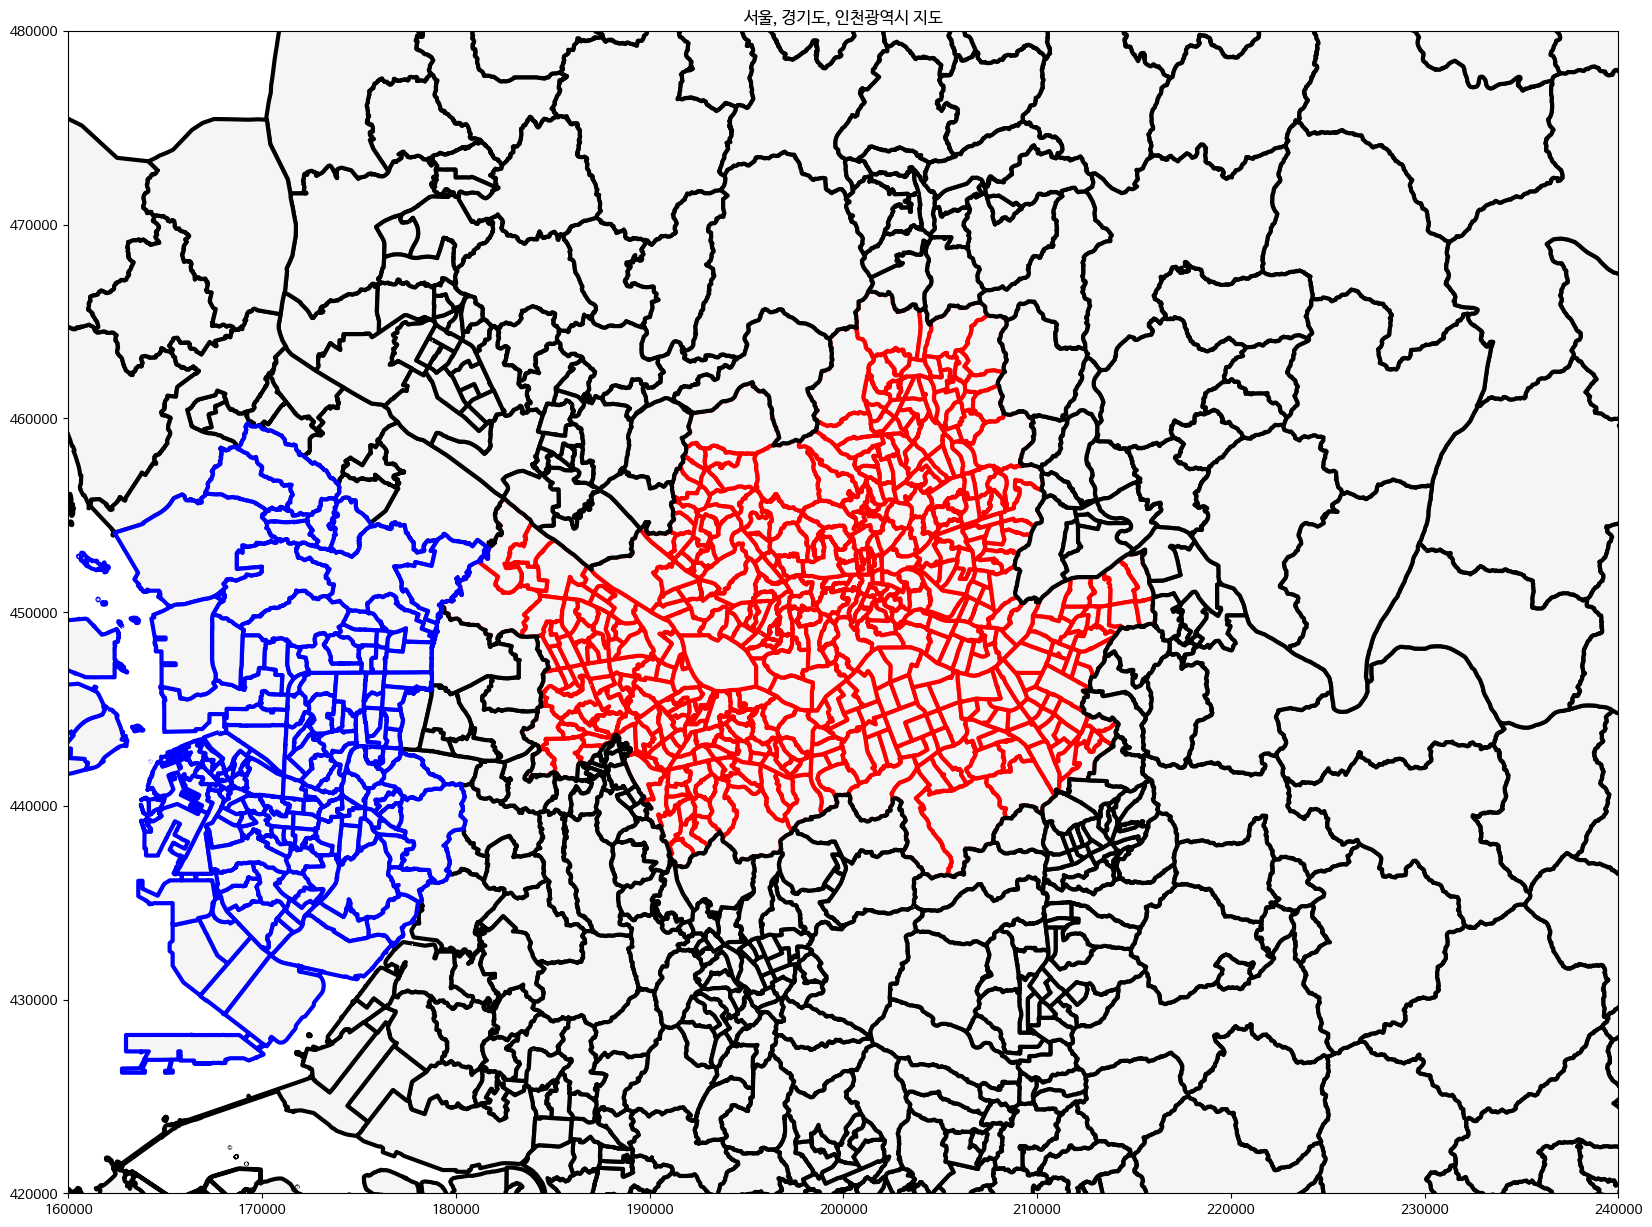

In [ ]:
import matplotlib.pyplot as plt
# 데이터 필터링: 서울시 한정
seoul_map = map[map['ADM_CD'] < 1200000]
gyeonggi_map = map[(map['ADM_CD'] >= 3000000) & (map['ADM_CD'] < 3200000)]
incheon_map = map[(map['ADM_CD'] >= 2300000) & (map['ADM_CD'] < 2400000)]

# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]
# 지도 데이터 가져오기
fig, ax = plt.subplots(figsize=(20, 20))


seoul_map.plot(ax=ax, color='whitesmoke', linewidth=3, edgecolor='red')
gyeonggi_map.plot(ax=ax, color='whitesmoke', linewidth=3,edgecolor='black')
incheon_map.plot(ax=ax, color='whitesmoke', linewidth=3,edgecolor='blue')

# xlim, ylim 범위 내에 있는지 확인
filtered_df_new = df_new[(df_new['x_centroid'] >= xlim[0]) & (df_new['x_centroid'] <= xlim[1]) &
                         (df_new['y_centroid'] >= ylim[0]) & (df_new['y_centroid'] <= ylim[1])]

# # 각 행정동 중앙에 생활인구이동량 표시
# for idx, row in filtered_df_new.iterrows():
#     ax.text(row['x_centroid'], row['y_centroid'], str(row['a_values']), fontsize=8, ha='center')

plt.title("서울, 경기도, 인천광역시 지도")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


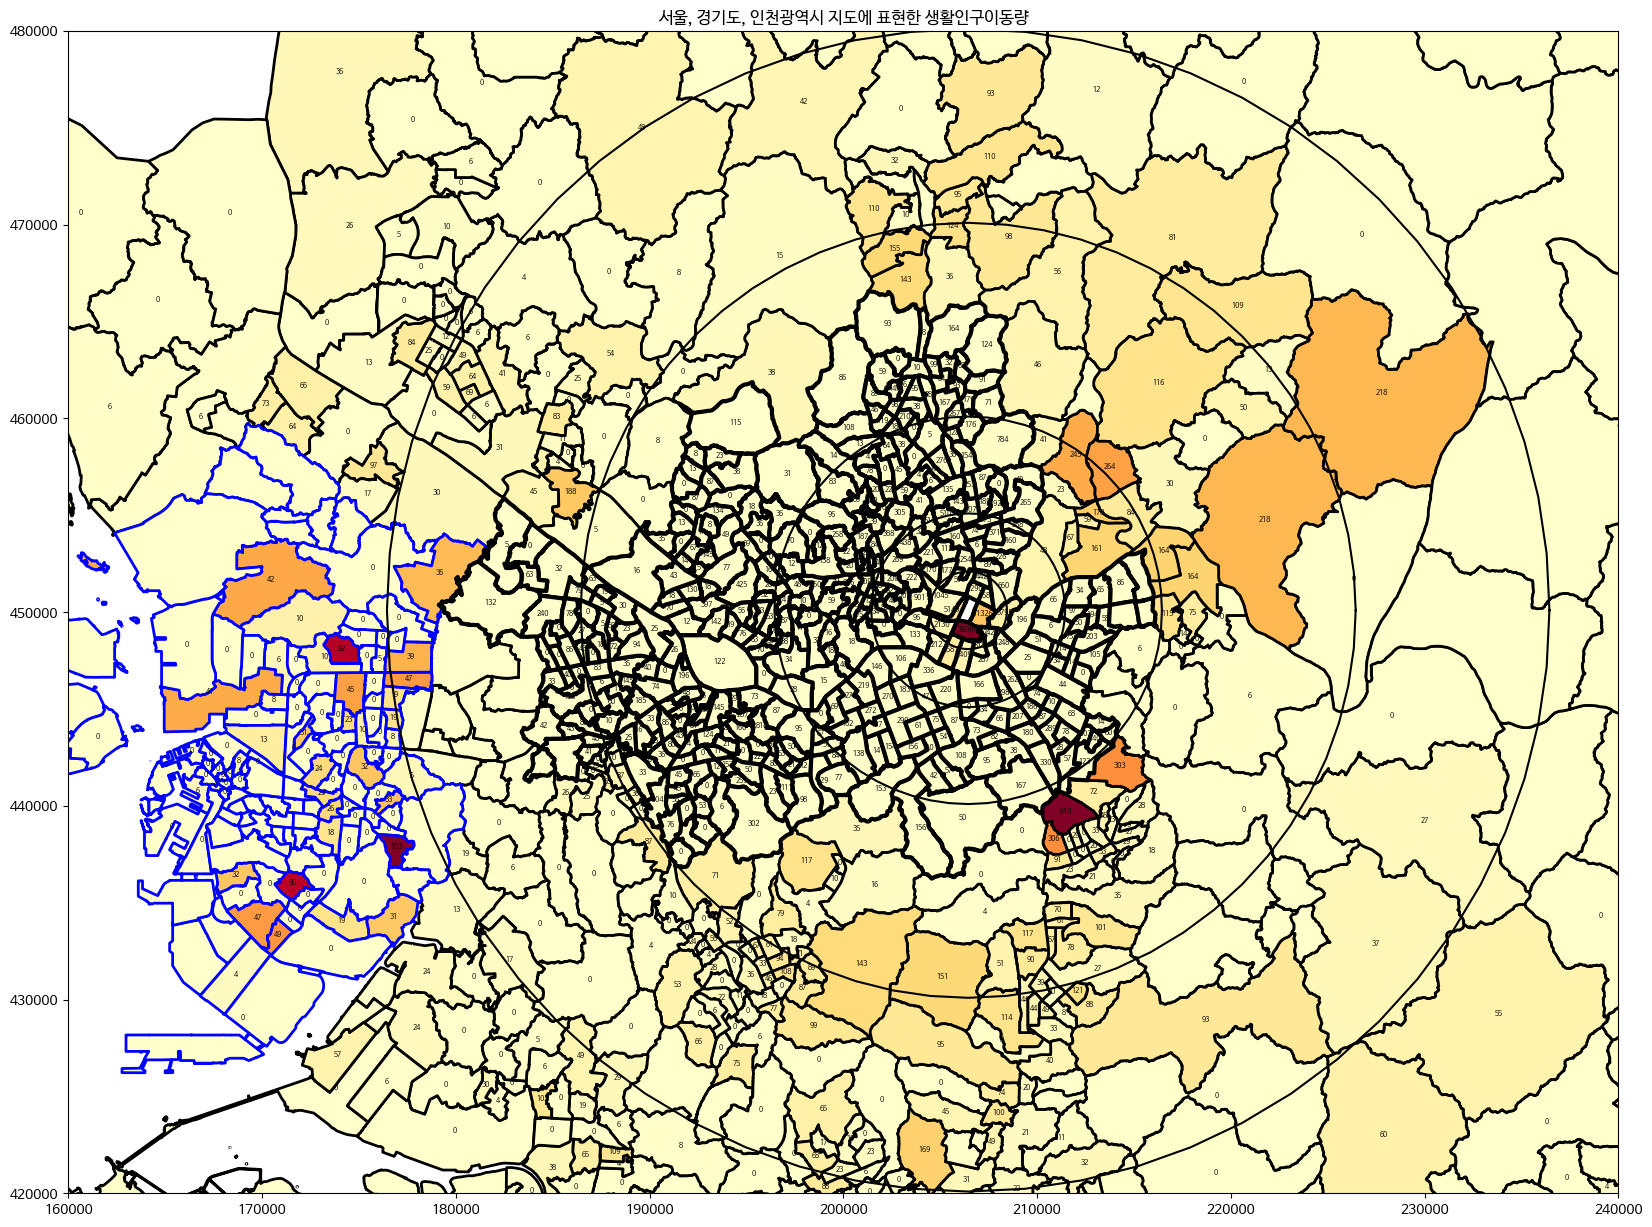

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 데이터 필터링
seoul_map = map[map['ADM_CD'] < 1200000]
seoul_map = seoul_map[seoul_map['ADM_NM'] != '군자동']
# seoul_map = seoul_map[seoul_map['ADM_NM'] != '능동']

gyeonggi_map = map[(map['ADM_CD'] >= 3000000) & (map['ADM_CD'] < 3200000)]
incheon_map = map[(map['ADM_CD'] >= 2300000) & (map['ADM_CD'] < 2400000)]

seoul_map = seoul_map.drop(columns=['x_centroid', 'y_centroid'])
gyeonggi_map = gyeonggi_map.drop(columns=['x_centroid', 'y_centroid'])
incheon_map = incheon_map.drop(columns=['x_centroid', 'y_centroid'])
# 지도 데이터 가져오기
fig, ax = plt.subplots(figsize=(20, 20))

# xlim, ylim 범위 내에 있는지 확인
filtered_df_new = df_new[(df_new['x_centroid'] >= xlim[0]) & (df_new['x_centroid'] <= xlim[1]) &
                         (df_new['y_centroid'] >= ylim[0]) & (df_new['y_centroid'] <= ylim[1])]

# 병합: df_new의 'dong' 열과 map의 'ADM_CD' 열을 기준으로
merged_seoul = seoul_map.set_index('ADM_CD').join(filtered_df_new.set_index('dong'))
merged_gyeonggi = gyeonggi_map.set_index('ADM_CD').join(filtered_df_new.set_index('dong'))
merged_incheon = incheon_map.set_index('ADM_CD').join(filtered_df_new.set_index('dong'))

# NaN 값을 0으로 채우기
merged_seoul = merged_seoul.fillna(0)
merged_gyeonggi = merged_gyeonggi.fillna(0)
merged_incheon = merged_incheon.fillna(0)

# 지도 위에 히트맵 그리기
# merged_seoul.plot(column='a_values', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='red', legend=False)
merged_gyeonggi.plot(column='a_values', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='black', legend=False)
merged_incheon.plot(column='a_values', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='blue', legend=False)

# 각 행정동 중앙에 생활인구이동량 표시
for idx, row in filtered_df_new.iterrows():
    ax.text(row['x_centroid'], row['y_centroid'], str(int(row['a_values'])), fontsize=5, ha='center', color='black')

gunja_centroid = map[map['ADM_CD'] == 1105054].geometry.centroid.iloc[0]


from shapely.geometry import Point
# 군자동의 중심점을 기준으로 2km의 원을 그리기
circle_2km = Point(gunja_centroid.x, gunja_centroid.y).buffer(2500)  # 2km

# # 이 원 내에 있는 행정동들의 centroid 찾기
# within_2km = merged_seoul[merged_seoul.geometry.centroid.within(circle_2km)]
# # 위에서 찾은 행정동들을 merged_seoul에서 제외하기
# filtered_seoul = merged_seoul.drop(within_2km.index)
# 이제 filtered_seoul 데이터를 이용하여 히트맵을 그립니다.
filtered_seoul = merged_seoul
filtered_seoul.plot(column='a_values', cmap='YlOrRd', linewidth=3, ax=ax, edgecolor='black', legend=False)


# 군자동의 중심을 기준으로 10km의 원 그리기 (주의: 10km를 좌표에 맞게 스케일링 해야 함, 예를 들어 0.1은 10km를 대략 나타냄)
circle = Point(gunja_centroid.x, gunja_centroid.y).buffer(10000)  # 여기서 10000은 10km를 나타냅니다.
                                                                  # 실제 스케일에 따라 조정이 필요할 수 있습니다.
circle1 = Point(gunja_centroid.x, gunja_centroid.y).buffer(5000)
circle2 = Point(gunja_centroid.x, gunja_centroid.y).buffer(20000)
circle3 = Point(gunja_centroid.x, gunja_centroid.y).buffer(30000)
circle4 = Point(gunja_centroid.x, gunja_centroid.y).buffer(2000)

ax.plot(*circle.exterior.xy, color='black')
ax.plot(*circle1.exterior.xy, color='black')
ax.plot(*circle2.exterior.xy, color='black')
ax.plot(*circle3.exterior.xy, color='black')
ax.plot(*circle4.exterior.xy, color='black')

plt.title("서울, 경기도, 인천광역시 지도에 표현한 생활인구이동량")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [ ]:
filtered_df_new

,dong,a_values,name,ADM_CD,x_centroid,y_centroid
2,1124066,180,가락1동,1124066.0,209505.008558,443670.182837
3,1124067,78,가락2동,1124067.0,211494.057528,443746.497944
4,1124065,289,가락본동,1124065.0,210688.039583,443874.859895
5,1117070,0,가리봉동,1117070.0,190029.517072,442284.172324
6,1118051,33,가산동,1118051.0,189651.129601,441615.044646
...,...,...,...,...,...,...
1142,1103051,0,후암동,1103051.0,198217.327612,449738.107184
1143,1106072,547,휘경1동,1106072.0,205459.169647,454406.654926
1144,1106073,160,휘경2동,1106073.0,205744.071491,453817.043763
1145,1120071,87,흑석동,1120071.0,196591.260391,444801.788938


<ipython-input-15-d3dc51fd6c80>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outlier_data['a_values_scaled'] = scaled_values
<ipython-input-15-d3dc51fd6c80>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_new['a_values_scaled'] = non_outlier_data['a_values_scaled']


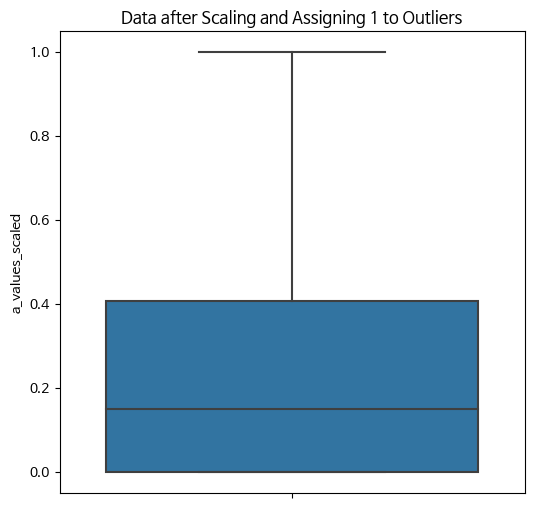

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# 1. 이상치 탐지
Q1 = filtered_df_new['a_values'].quantile(0.25)
Q3 = filtered_df_new['a_values'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = filtered_df_new[(filtered_df_new['a_values'] < lower_bound) | (filtered_df_new['a_values'] > upper_bound)]
non_outlier_data = filtered_df_new[(filtered_df_new['a_values'] >= lower_bound) & (filtered_df_new['a_values'] <= upper_bound)]

# 2. 이상치를 제외하고 데이터 스케일링
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(non_outlier_data[['a_values']])
non_outlier_data['a_values_scaled'] = scaled_values

# 3. 스케일링된 값에서 이상치 위치에 1 대입
filtered_df_new['a_values_scaled'] = non_outlier_data['a_values_scaled']
filtered_df_new.loc[outliers.index, 'a_values_scaled'] = 1

# boxplot으로 시각화
plt.figure(figsize=(6, 6))
sns.boxplot(y=filtered_df_new['a_values_scaled'])
plt.title('Data after Scaling and Assigning 1 to Outliers')
plt.show()


In [ ]:
filtered_df_new

,dong,a_values,name,ADM_CD,x_centroid,y_centroid,a_values_scaled
2,1124066,180,가락1동,1124066.0,209505.008558,443670.182837,0.841121
3,1124067,78,가락2동,1124067.0,211494.057528,443746.497944,0.364486
4,1124065,289,가락본동,1124065.0,210688.039583,443874.859895,1.000000
5,1117070,0,가리봉동,1117070.0,190029.517072,442284.172324,0.000000
6,1118051,33,가산동,1118051.0,189651.129601,441615.044646,0.154206
...,...,...,...,...,...,...,...
1142,1103051,0,후암동,1103051.0,198217.327612,449738.107184,0.000000
1143,1106072,547,휘경1동,1106072.0,205459.169647,454406.654926,1.000000
1144,1106073,160,휘경2동,1106073.0,205744.071491,453817.043763,0.747664
1145,1120071,87,흑석동,1120071.0,196591.260391,444801.788938,0.406542


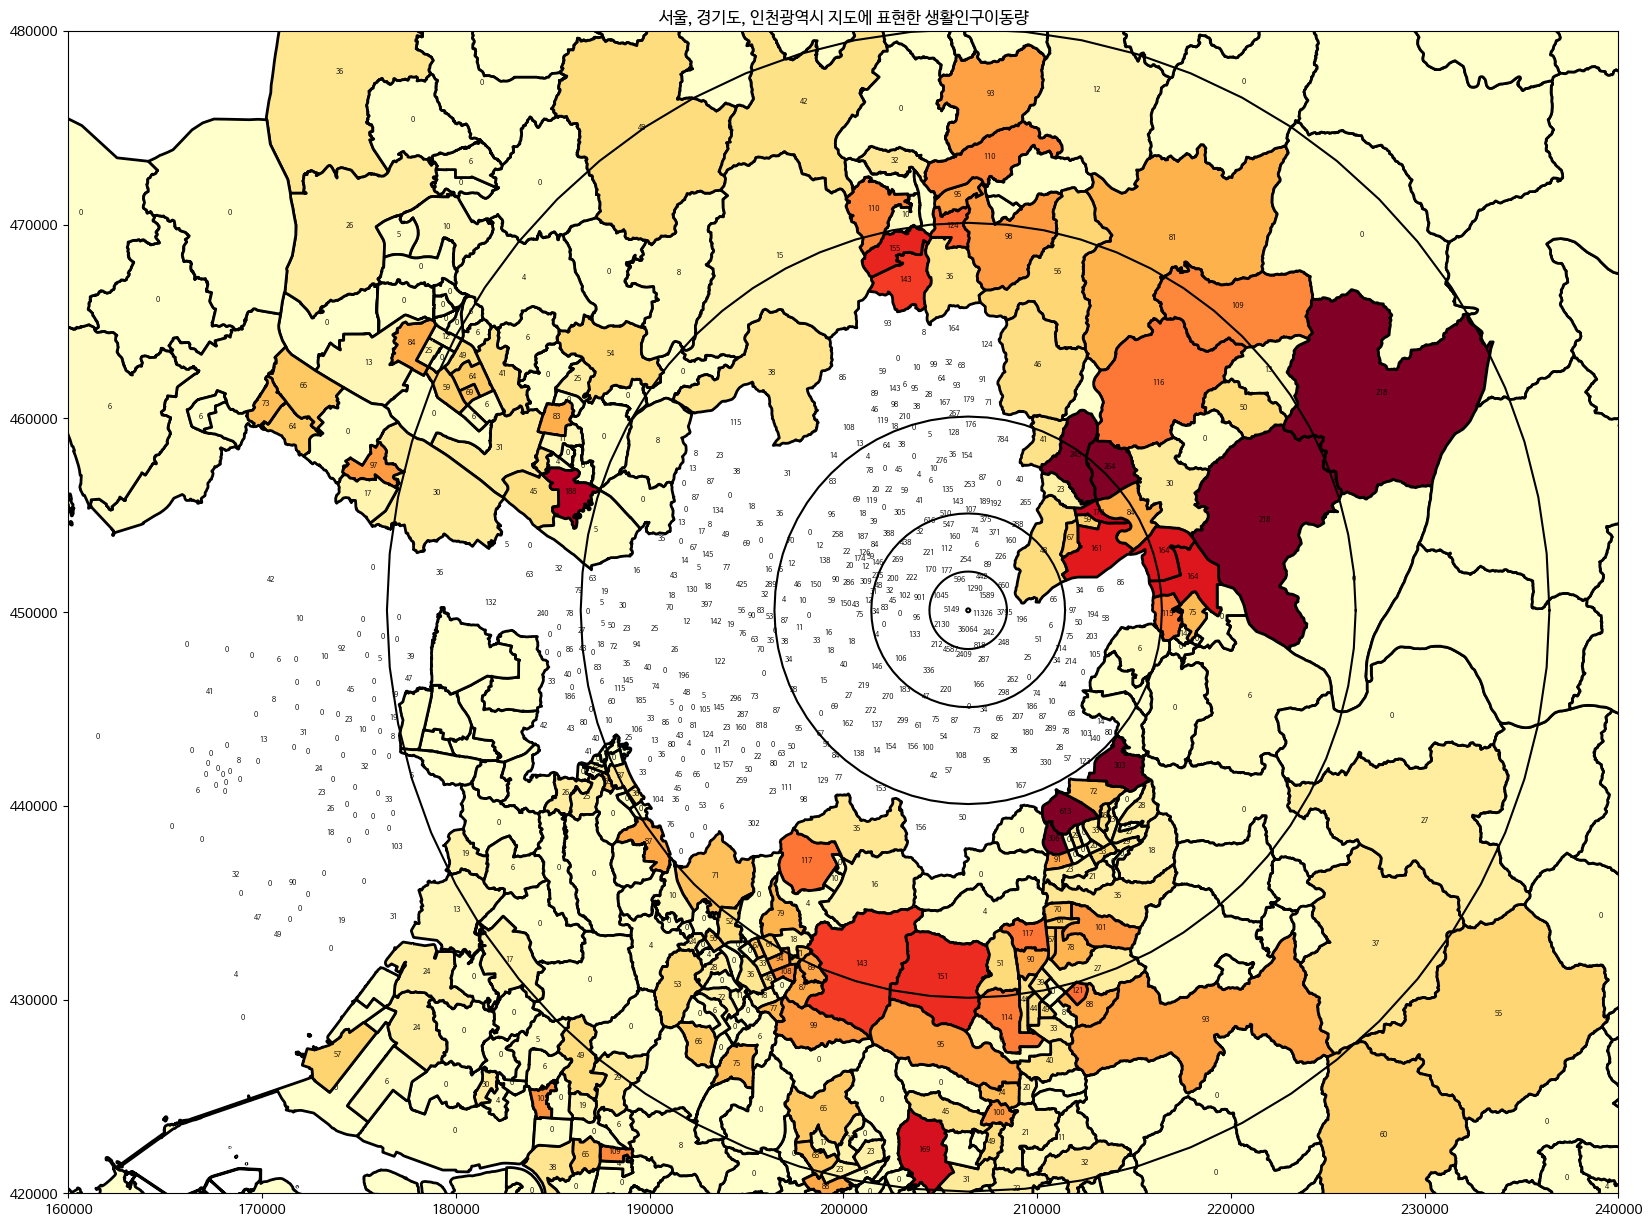

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 데이터 필터링
seoul_map = map[map['ADM_CD'] < 1200000]
seoul_map = seoul_map[seoul_map['ADM_NM'] != '군자동']
# seoul_map = seoul_map[seoul_map['ADM_NM'] != '능동']

gyeonggi_map = map[(map['ADM_CD'] >= 3000000) & (map['ADM_CD'] < 3200000)]
incheon_map = map[(map['ADM_CD'] >= 2300000) & (map['ADM_CD'] < 2400000)]

seoul_map = seoul_map.drop(columns=['x_centroid', 'y_centroid'])
gyeonggi_map = gyeonggi_map.drop(columns=['x_centroid', 'y_centroid'])
incheon_map = incheon_map.drop(columns=['x_centroid', 'y_centroid'])
# 지도 데이터 가져오기
fig, ax = plt.subplots(figsize=(20, 20))

# 병합: df_new의 'dong' 열과 map의 'ADM_CD' 열을 기준으로
merged_seoul = seoul_map.set_index('ADM_CD').join(filtered_df_new.set_index('dong'))
merged_gyeonggi = gyeonggi_map.set_index('ADM_CD').join(filtered_df_new.set_index('dong'))
merged_incheon = incheon_map.set_index('ADM_CD').join(filtered_df_new.set_index('dong'))

# NaN 값을 0으로 채우기
merged_seoul = merged_seoul.fillna(0)
merged_gyeonggi = merged_gyeonggi.fillna(0)
merged_incheon = merged_incheon.fillna(0)

# 지도 위에 히트맵 그리기
# merged_seoul.plot(column='a_values', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='red', legend=False)
merged_gyeonggi.plot(column='a_values_scaled', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='black', legend=False)
# merged_incheon.plot(column='a_values_scaled', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='blue', legend=False)

# 각 행정동 중앙에 생활인구이동량 표시
for idx, row in filtered_df_new.iterrows():
    ax.text(row['x_centroid'], row['y_centroid'], str(int(row['a_values'])), fontsize=5, ha='center', color='black')

gunja_centroid = map[map['ADM_CD'] == 1105054].geometry.centroid.iloc[0]


from shapely.geometry import Point
# 군자동의 중심점을 기준으로 2km의 원을 그리기
circle_2km = Point(gunja_centroid.x, gunja_centroid.y).buffer(2500)  # 2km
# 이 원 내에 있는 행정동들의 centroid 찾기
within_2km = merged_seoul[merged_seoul.geometry.centroid.within(circle_2km)]
# 위에서 찾은 행정동들을 merged_seoul에서 제외하기
filtered_seoul = merged_seoul.drop(within_2km.index)
# 이제 filtered_seoul 데이터를 이용하여 히트맵을 그립니다.
# filtered_seoul.plot(column='a_values_scaled', cmap='YlOrRd', linewidth=1, ax=ax, edgecolor='blue', legend=False)


# 군자동의 중심을 기준으로 10km의 원 그리기 (주의: 10km를 좌표에 맞게 스케일링 해야 함, 예를 들어 0.1은 10km를 대략 나타냄)
circle0 = Point(gunja_centroid.x, gunja_centroid.y).buffer(100)
circle = Point(gunja_centroid.x, gunja_centroid.y).buffer(10000)  # 여기서 10000은 10km를 나타냅니다.
                                                                  # 실제 스케일에 따라 조정이 필요할 수 있습니다.
circle1 = Point(gunja_centroid.x, gunja_centroid.y).buffer(5000)
circle2 = Point(gunja_centroid.x, gunja_centroid.y).buffer(20000)
circle3 = Point(gunja_centroid.x, gunja_centroid.y).buffer(30000)
circle4 = Point(gunja_centroid.x, gunja_centroid.y).buffer(2000)

ax.plot(*circle0.exterior.xy, color='black')
ax.plot(*circle.exterior.xy, color='black')
ax.plot(*circle1.exterior.xy, color='black')
ax.plot(*circle2.exterior.xy, color='black')
ax.plot(*circle3.exterior.xy, color='black')
ax.plot(*circle4.exterior.xy, color='black')

plt.title("서울, 경기도, 인천광역시 지도에 표현한 생활인구이동량")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [ ]:
top_10 = merged_gyeonggi.nlargest(10, 'a_values')
print('경기도')
print(top_10['ADM_NM'])
top_10 = merged_incheon.nlargest(10, 'a_values')
print('인천')
print( top_10['ADM_NM'])
top_10 = filtered_seoul.nlargest(10, 'a_values')
print('서울')
print( top_10['ADM_NM'])

경기도
3102167     복정동
3102154    태평1동
3118065     위례동
3113058    다산1동
3112052     동구동
3113011     와부읍
3113011     와부읍
3113011     화도읍
3113011     화도읍
3110166    행신2동
Name: ADM_NM, dtype: object
인천
2305064     만수6동
2307051     효성1동
2304053     연수1동
2304058     동춘2동
2304057     동춘1동
2306065     삼산1동
2306062     청천2동
2308051    검암경서동
2308073    신현원창동
2307058    작전서운동
Name: ADM_NM, dtype: object
서울
1104055     사근동
1120053    상도1동
1111056    공릉2동
1106071     회기동
1106072    휘경1동
1106089    이문1동
1106082     제기동
1113075     신촌동
1114066     서교동
1108060     안암동
Name: ADM_NM, dtype: object


In [ ]:
stop

NameError: ignored

##시각화

In [ ]:
import geopandas as gpd
from google.colab import drive
drive.mount('/content/gdrive')
import matplotlib.pyplot as plt
# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]
# 데이터 필터링: 서울, 경기도, 인천광역시 한정

# 데이터 필터링: 서울시 한정
seoul_map = map[map['ADM_CD'] < 12000000]
gyeonggi_map = map[(map['ADM_CD'] >= 31000000) & (map['ADM_CD'] < 32000000)]
incheon_map = map[(map['ADM_CD'] >= 23000000) & (map['ADM_CD'] < 24000000)]

# 각 행정동의 중심 계산
centroids = map.geometry.centroid

# combined_list에서 a값만 가져오기
a_values = [item[0] for item in combined_list]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(20, 20))
seoul_map.plot(ax=ax, color='whitesmoke', edgecolor='red')
gyeonggi_map.plot(ax=ax, color='whitesmoke', edgecolor='black')
incheon_map.plot(ax=ax, color='whitesmoke', edgecolor='blue')

# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]

# 각 행정동 중앙에 생활인구이동량 표시 (a 값만, xlim과 ylim 영역에 포함된 중심만)
for idx, (x, y, label) in enumerate(zip(centroids.x, centroids.y, a_values)):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
        ax.text(x, y, str(label), fontsize=8, ha='center')

# 경기도 행정동의 중심 계산
gyeonggi_centroids = gyeonggi_map.geometry.centroid
# 경기도 행정동에 해당하는 생활인구 이동량 a_values 추출
gyeonggi_a_values = a_values[len(seoul_map):len(seoul_map)+len(gyeonggi_map)]
gyeonggi_map.plot(ax=ax, color='whitesmoke', edgecolor='black')
# 경기도 행정동 중앙에 생활인구이동량 표시 (a 값만)
for x, y, label in zip(gyeonggi_centroids.x, gyeonggi_centroids.y, gyeonggi_a_values):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:  # xlim, ylim 범위 내에 있는지 확인
        ax.text(x, y, str(label), fontsize=8, ha='center')

plt.title("서울, 경기도, 인천광역시 지도")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()







In [ ]:
map.head()
df_all
# len(df_all)

In [ ]:
import geopandas as gpd
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({'ADM_CD': 'int'})
df1.info()

map = df1

# 데이터 필터링: 서울, 경기도, 인천광역시 한정
seoul_map = map[map['ADM_CD'] < 12000000]
gyeonggi_map = map[(map['ADM_CD'] >= 31000000) & (map['ADM_CD'] < 32000000)]
incheon_map = map[(map['ADM_CD'] >= 23000000) & (map['ADM_CD'] < 24000000)]

# 각 행정동의 중심 계산
centroids = map.geometry.centroid

# combined_list에서 a값만 가져오기
a_values = [item[0] for item in combined_list]
print(len(a_values))
# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]

# 각 행정동 중앙에 생활인구이동량 표시 (a 값만, xlim과 ylim 영역에 포함된 중심만)
data_list = []

for idx, (x, y, label) in enumerate(zip(centroids.x, centroids.y, a_values)):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
        data_list.append({"x": x, "y": y, "population_movement": label})

# 경기도 행정동의 중심 계산 및 데이터프레임에 추가
gyeonggi_centroids = gyeonggi_map.geometry.centroid
gyeonggi_a_values = a_values[len(seoul_map):len(seoul_map)+len(gyeonggi_map)]

for x, y, label in zip(gyeonggi_centroids.x, gyeonggi_centroids.y, gyeonggi_a_values):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
        data_list.append({"x": x, "y": y, "population_movement": label})

# DataFrame으로 변환
df_centroid_pop = pd.DataFrame(data_list)


print(len(df_centroid_pop))
print(df_centroid_pop)


In [ ]:
map.head()

In [ ]:
df_centroid_pop

In [ ]:
import geopandas as gpd
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({'ADM_CD': 'int'})
map = df1

# Add population_movement to our main geopandas dataframes
map = map.merge(df_centroid_pop[['ADM_CD', 'population_movement']], on='ADM_CD', how='left')

# Filter regions
seoul_map = map[map['ADM_CD'] < 12000000]
gyeonggi_map = map[(map['ADM_CD'] >= 31000000) & (map['ADM_CD'] < 32000000)]
incheon_map = map[(map['ADM_CD'] >= 23000000) & (map['ADM_CD'] < 24000000)]

fig, ax = plt.subplots(figsize=(20, 20))

# Draw the colored maps based on population_movement
seoul_map.plot(ax=ax, column='population_movement', cmap='viridis', legend=True)
gyeonggi_map.plot(ax=ax, column='population_movement', cmap='viridis')
incheon_map.plot(ax=ax, column='population_movement', cmap='viridis')

# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]

plt.title("서울, 경기도, 인천광역시 생활인구 이동량 히트맵")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()



In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# 생략: 데이터 로딩 및 전처리 코드 ...

# xlim과 ylim 범위 설정
xlim = [160000,240000]
ylim = [420000,480000]

# xlim과 ylim 범위에 있는 행정동만 필터링
map_in_xlim = map[map.bounds.minx >= xlim[0]]
map_in_xlim = map_in_xlim[map_in_xlim.bounds.maxx <= xlim[1]]
map_in_ylim = map_in_xlim[map_in_xlim.bounds.miny >= ylim[0]]
filtered_map = map_in_ylim[map_in_ylim.bounds.maxy <= ylim[1]]

# 해당 행정동의 생활인구 이동량 값만 가져오기
filtered_a_values = [a_values[i] for i in filtered_map.index]

# 히트맵 그리기: 색상은 생활인구 이동량에 따라 지정됨
fig, ax = plt.subplots(figsize=(20, 20))
filtered_map.plot(column=np.array(filtered_a_values), cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title("서울, 경기도, 인천광역시 지도 내의 생활인구 이동량 히트맵")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [ ]:
# 경기도 행정동의 중심 계산
gyeonggi_centroids = gyeonggi_map.geometry.centroid

# 경기도 행정동에 해당하는 생활인구 이동량 a_values 추출
gyeonggi_a_values = a_values[len(seoul_map):len(seoul_map)+len(gyeonggi_map)]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 12))
gyeonggi_map.plot(ax=ax, color='whitesmoke', edgecolor='black')

# 경기도 행정동 중앙에 생활인구이동량 표시 (a 값만)
for x, y, label in zip(gyeonggi_centroids.x, gyeonggi_centroids.y, gyeonggi_a_values):
    ax.text(x, y, str(label), fontsize=8, ha='center')

plt.title("경기도 지도 - 생활인구 이동량 표시")
plt.xlim([160000,240000])
plt.ylim([420000,480000])
plt.show()


In [ ]:
print(dong_name_real)
print(dong_name_two)
print(len(combined_list))
print(len(combined_list[1]))

In [ ]:
# scaler = MinMaxScaler()

# # 스케일링 적용
# scaled_population_movement = scaler.fit_transform(population_moving_amount)

# # 스케일링된 데이터 출력
# print(scaled_population_movement)

In [ ]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name_real
node_labels = {i: dong_name[i] for i in range(len(dong_name))}
# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향 그래프 생성
G = nx.DiGraph()
for i, district in enumerate(districts):
    G.add_node(i, label=district)

for i in range(len(districts)):
    for j in range(len(dong_name_two)):
        if i != j:  # i와 j가 다른 경우에만 간선을 추가
          weight = population_movement[i, j]
          G.add_edge(i, j, weight=weight)



In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name
node_labels = {i: dong_name[i] for i in range(len(dong_name))}
# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향성이 없는 그래프 생성
G = nx.Graph()
for i, district in enumerate(districts):
    G.add_node(i, label=district)

for i in range(len(districts)):
    for j in range(len(dong_name_two)):
        if i != j:  # i와 j가 다른 경우에만 간선을 추가
            weight = population_movement[i, j]
            G.add_edge(i, j, weight=weight)

# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 위치 결정을 위한 레이아웃
edge_weights = nx.get_edge_attributes(G, 'weight')  # 간선의 가중치 가져오기

# 노드와 간선 그리기
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=2000, font_size=12, font_weight='bold', width=list(edge_weights.values()), edge_color='gray')

# 간선의 가중치를 라벨로 표시
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

plt.title("서울 자치구 이동량 그래프")
plt.show()


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name
node_labels = {i: dong_name[i] for i in range(len(dong_name))}
# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향성이 없는 그래프 생성
G = nx.Graph()
for i, district in enumerate(districts):
    G.add_node(i, label=district)

for i in range(len(districts)):
    for j in range(1):
        if i != j:  # i와 j가 다른 경우에만 간선을 추가
            weight = population_movement[i, j] ;
            G.add_edge(i, j, weight=weight)
# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 위치 결정을 위한 레이아웃
edge_weights = nx.get_edge_attributes(G, 'weight')  # 간선의 가중치 가져오기

fig, ax = plt.subplots(figsize=(20, 15))  # 그래프 크기를 조절

# 노드와 간선 그리기
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=1000, font_size=10, font_weight='bold',  edge_color='gray', ax=ax)

# 간선의 가중치를 라벨로 표시
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, ax=ax)

plt.title("서울 자치구 이동량 그래프")
plt.show()


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name
node_labels = {i: dong_name[i] for i in range(len(dong_name))}

# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향성이 없는 그래프 생성
G = nx.Graph()

for i, district in enumerate(districts):
    G.add_node(i, label=district)

j = 0  # 중심 노드
nodes_to_remove = []  # 가중치가 0인 노드를 저장하는 리스트
for i in range(len(districts)):
    if i != j:
        weight = population_movement[i, j]
        if weight != 0:  # 가중치가 0이 아닌 노드만 간선 추가
            G.add_edge(i, j, weight=weight)
        else:
            nodes_to_remove.append(i)

# 가중치가 0인 노드를 제거
G.remove_nodes_from(nodes_to_remove)

# 원형 레이아웃 계산
pos = {}
center = np.array([0.5, 0.5])
radius = 0.4  # 원의 반지름
for node in G.nodes():
    if node == j:
        pos[node] = center
    else:
        theta = float(node) / (len(G.nodes()) - 1) * 2 * np.pi
        pos[node] = center + np.array([radius * np.cos(theta), radius * np.sin(theta)])

edge_weights = {(i, j): G[i][j]['weight'] for i, j in G.edges()}

fig, ax = plt.subplots(figsize=(20, 15))  # 그래프 크기를 조절

# 노드와 간선 그리기
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=1000, font_size=10, font_weight='bold', edge_color='gray', ax=ax)

# 간선의 가중치를 라벨로 표시
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=8, ax=ax)

plt.title("서울 자치구 이동량 그래프")
plt.show()



In [ ]:
file_seuol_1 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(자치구별 상권변화지표) (1).csv'
graphic1 = pd.read_csv(file_seuol_1, encoding='cp949', index_col = None)
graphic1.head()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 행정동 경계 데이터 로드

# 예시 데이터 생성 (실제 데이터로 교체 필요)
data = {
    '행정동이름': [districts[node] for node in total_degrees],
    '값': [total_degrees[node] for node in total_degrees]
}

df = pd.DataFrame(data)


# 행정동 이름을 기준으로 데이터 병합
merged = map.set_index('ADM_NM').join(df.set_index('행정동이름'))
# Q1, Q3 계산
Q1 = merged['값'].quantile(0.25)
Q3 = merged['값'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_filtered = merged[(merged['값'] >= lower_bound) & (merged['값'] <= upper_bound)]
merged_filtered2 = merged[merged['값'] >= upper_bound]
print(merged_filtered2.head())
# scaler = MinMaxScaler()
# merged['scaled_data'] = scaler.fit_transform( merged[['값']] )
print(merged.head())
# merged.boxplot(column = 'scaled_data')
# 히트맵 그리기
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_filtered.plot(column = '값', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,legend_kwds = {'shrink': 0.5})
merged_filtered2.plot(column = '값', cmap='Spectral', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,legend_kwds = {'shrink': 0.5})
# map2[map2['TRDAR_SE_1'] == '골목상권'].convex_hull.plot(color='yellow', edgecolor='k', ax=ax)
# map2[map2['TRDAR_SE_1'] == '발달상권'].convex_hull.plot(color='green', edgecolor='k', ax=ax)
plt.title('서울 행정동 히트맵 예시')
plt.show()


#dummy

In [ ]:
# # 스펙트럼 클러스터링
# adj_matrix = nx.adjacency_matrix(G).todense()
# n_clusters = 3  # 클러스터 개수 설정
# clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0).fit(adj_matrix)
# node_colors = clustering.labels_
# # 클러스터링 결과 출력
# print("Cluster Labels:", clustering.labels_)


# # 각 노드의 나가는 간선과 들어오는 간선의 가중치 합을 계산
# total_degrees = {node: G.out_degree(node, weight='weight') + G.in_degree(node, weight='weight') for node in G.nodes()}
# # 연결 중심성 값을 기준으로 노드를 정렬하고 상위 10개를 선택
# top_10_central_nodes = sorted(total_degrees, key=total_degrees.get, reverse=True)[:10]
# print("연결 중심성 상위 10위 노드:")
# for rank, node in enumerate(top_10_central_nodes, 1):
#     print(f"{rank}. {districts[node]}, 연결 중심성 값: {total_degrees[node]}")

# # 각 노드에 연결된 간선의 가중치를 기록하는 행렬 생성
# matrix_size = len(districts)
# connection_matrix = np.zeros((matrix_size, matrix_size))
# for i in range(matrix_size):
#     for j in range(len(dong_name_two)):
#         connection_matrix[i, j] = G.get_edge_data(i, j, default={'weight': 0})['weight']
# # Pearson 상관계수 계산
# correlation_matrix = np.corrcoef(connection_matrix)
# # 상관계수가 0.8 이상인 노드 쌍만 선택
# high_correlation_edges = []
# for i in range(matrix_size):
#     for j in range(len(dong_name_two)):
#         if i != j and correlation_matrix[i, j] >= 0.8:
#             high_correlation_edges.append((i, j))
# print("피어슨 상관계수 0.8이상인 노드쌍",high_correlation_edges[:10])

# # 매개 중심성 계산
# betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
# # 상위 10개 노드 출력 및 저장
# sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:4]
# top_10_nodes = [item[0] for item in sorted_betweenness]
# print("Top 10 nodes by 매개중심성:")
# for node, value in sorted_betweenness:
#     print(f"{node_labels[node]}: {value:.4f}")

# # 아이겐벡터 중심성 계산
# eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

# # 상위 10개의 아이겐벡터 중심성 노드 출력
# top_10_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
# print("Top 10 nodes by 아이겐벡터 중심성 노드:")
# for node, centrality in top_10_eigenvector:
#     print(f"Node {node_labels[node]}: {centrality:.4f}")